In [ ]:
!pip install pandas_ta
!pip install pmdarima

In [ ]:
!pip install pystan==2.19
!pip install fbprophet
!pip install pytrends

In [ ]:
!pip install yfinance

In [5]:
import random 
import pandas_ta as ta
import numpy as np 
import pandas as pd 
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from fbprophet import Prophet
from pandas_datareader import data
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
from pytrends.request import TrendReq
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

from matplotlib.ticker import FixedFormatter, FixedLocator

# Financial Market

<img src="https://time.com/nextadvisor/wp-content/uploads/2021/09/na-what-are-cyclical-stocks.jpg" width="600px">

# Search stock data

In [7]:
def show_table(dataframe):
    colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]
    fig =  ff.create_table(dataframe, colorscale=colorscale, index=True)
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 14
    fig.show()

    
def dataframe_format(df, columns):
    for column in columns:
        df[column] = df[column].round(3)
    return df

def format_index(df: dict):
    df['DateIndex'] = df.index
    df['DateIndex'] = pd.to_datetime(df['DateIndex']).dt.date
    return df

def download_dataframe(name: str, start_date: str, end_date: str):
    df = yf.download(tickers=name, start=start_date, end=end_date)
    for column in ["High", "Low", "Open", "Close", "Adj Close"]:
        df[column] = df[column].round(3)
       # df[column] = pd.to_numeric(df[column], downcast="float")
    return df

def download_list_stocks(stocks: list, field: str, start_date: str, end_date: str):
    stocks_dataframe = pd.DataFrame()
    for stock in stocks:
        stocks_dataframe[stock] = download_dataframe(stock, start_date=start_date, end_date=end_date)[field]
    return stocks_dataframe
                                                     
def get_random_color():
    r1 = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r1(),r1(),r1())

def save_dataframe(df: dict, file_path: str):
    df.read_csv(file_path)
    print("Success saved!")

dataframe = download_dataframe(name='SUMAS.IS', start_date='2019-01-01', end_date='2022-09-18')

[*********************100%***********************]  1 of 1 completed


In [8]:
dataframe = format_index(dataframe)
show_table(dataframe.head(10))

In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 938 entries, 2019-01-01 to 2022-09-16
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       938 non-null    float64
 1   High       938 non-null    float64
 2   Low        938 non-null    float64
 3   Close      938 non-null    float64
 4   Adj Close  938 non-null    float64
 5   Volume     938 non-null    int64  
 6   DateIndex  938 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 58.6+ KB


In [10]:
show_table(pd.DataFrame(dataframe.describe()))

In [11]:
show_table(dataframe[dataframe['High'] >= 21.00].head(10))

# Candlestick plot data

In [14]:
def get_candles_plot(df: dict, title: str, stock_name=''):
    fig = go.Figure(data=[go.Candlestick(x=dataframe['DateIndex'],
          open=dataframe['Open'],
          high=dataframe['High'],
          low=dataframe['Low'],
          close=dataframe['Close'])])
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_layout(title=f'{title}: {stock_name}', paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()
    
get_candles_plot(dataframe, 'Stock price', 'SUMAS.IS')

In [15]:
fig = px.bar(dataframe, x='DateIndex', y='Volume')
fig.update_layout(title=f'Trading volume: SUMAS.IS', barmode='stack', paper_bgcolor='white', plot_bgcolor="white", font_color="black")
fig.show()

# Moving Average

In [16]:
dataframe.ta.sma(close='Close', length=5, append=True)
dataframe.ta.sma(close='Close', length=10, append=True)
dataframe.ta.sma(close='Close', length=20, append=True)
dataframe.ta.sma(close='Close', length=200, append=True)
dataframe.ta.ema(close='Close', length=5, append=True)

Date
2019-01-01          NaN
2019-01-02          NaN
2019-01-03          NaN
2019-01-04          NaN
2019-01-07     6.902000
                ...    
2022-09-12    76.026662
2022-09-13    76.017774
2022-09-14    75.011850
2022-09-15    75.174566
2022-09-16    74.916378
Name: EMA_5, Length: 938, dtype: float64

In [17]:
dataframe = dataframe_format(dataframe, ["SMA_5", "SMA_10", "SMA_20", "SMA_200", "EMA_5"])
show_table(dataframe.head(10))

In [18]:
def get_candles_plot_avg(df: dict, title: str, stock_name='', average_fields=False):
    fig = go.Figure(data=[go.Candlestick(x=dataframe['DateIndex'],
          open=dataframe['Open'],
          high=dataframe['High'],
          low=dataframe['Low'],
          close=dataframe['Close'])])
    
    if average_fields:
        for field_avg, colors in zip(average_fields["avg_mov"],
                                     average_fields["colors"]):
            fig.add_trace(
                go.Scatter(
                    x=df.index,
                    y=df[field_avg],
                    line=dict(color=colors, width=2),
                    name=field_avg
                )
            )
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_layout(title=f'{title}: {stock_name}', width=1800, height=900, paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()
    
settings_avg = {"avg_mov": ["SMA_10", "SMA_20", "SMA_200"], "colors": ["blue", "pink", "purple"]}
get_candles_plot_avg(dataframe, 'Stock price', 'PETR3.SA', settings_avg)

In [21]:
from datetime import datetime
from datetime import timedelta

date_time_filter = '2022-01-05'
datetime_filter = dataframe[dataframe.index <= date_time_filter]
settings_avg = {"avg_mov": ["SMA_10", "SMA_20", "SMA_200"], "colors": ["blue", "pink", "purple"]}
get_candles_plot_avg(datetime_filter, 'Stock price <= 2020-01-05', 'SUMAS.IS', settings_avg)

# Compare stocks list in wallet

In [33]:
stocks_list = ["SUMAS.IS", "LBS=F","ORMA.IS", "YONGA.IS","XU100.IS",
               "XU030.IS","EURTRY=X","TRY=X"]
dataframe_stocks = download_list_stocks(stocks_list, "Close", "2020-09-01", "2022-09-18")
show_table(dataframe_stocks.head(100))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [34]:
dataframe_stocks.isnull().sum()
dataframe_stocks.dropna(inplace=True)

In [35]:
def get_stocks_histplot(df: dict, stocks: list):
    for index, stock in enumerate(stocks):
        f, (ax1) = plt.subplots(1, 1, figsize=(14, 2))
        v_dist_1 = df[f"{stock}"].values
        sns.histplot(v_dist_1, ax=ax1, color=get_random_color(), kde=True)
        ax1.set_title(f"{stock}: Close", fontsize=15)
        
        
def get_stock_histplot_central_tendency(df: dict, stocks: list):
    for index, stock in enumerate(stocks):
        f, (ax1) = plt.subplots(1, 1, figsize=(14, 5))
        v_dist_1 = df[f"{stock}"].values
        sns.histplot(v_dist_1, ax=ax1, color=get_random_color(), kde=True)
        
        mean=df[f"{stock}"].mean()
        median=df[f"{stock}"].median()
        mode=df[f"{stock}"].mode().values[0]
        
        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Mean")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.legend()


In [36]:
dataframe_stocks = format_index(dataframe_stocks)
show_table(dataframe_stocks.head(4))

In [37]:
def stock_plot_line(df: dict, stocks: list, title=''):
    fig = go.Figure()
    for stock in stocks:
        fig.add_trace(go.Scatter(x=df['DateIndex'], y=df[stock],
                    mode='lines',
                    name=stock))
    fig.update_layout(title=title, paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

stock_plot_line(dataframe_stocks, stocks_list, title='Stocks price - close')

# Stocks histogram

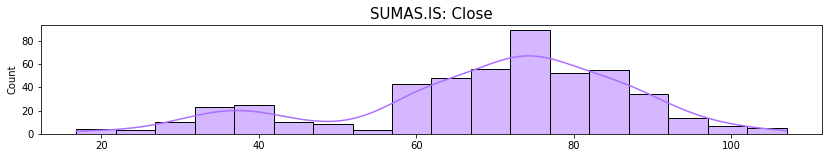

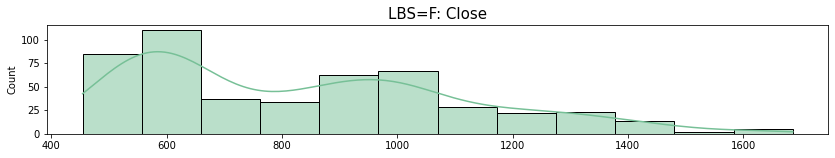

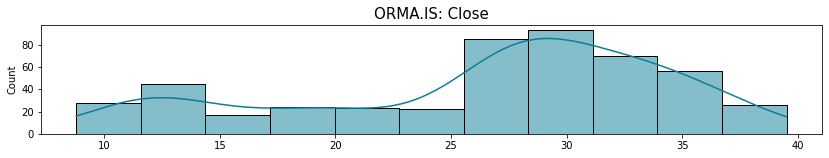

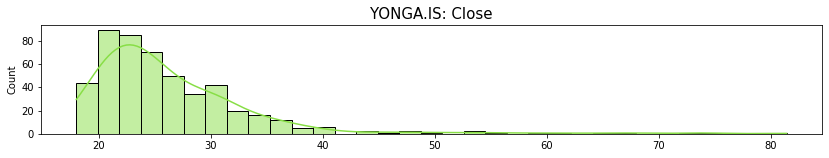

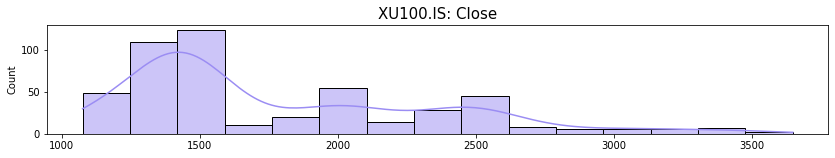

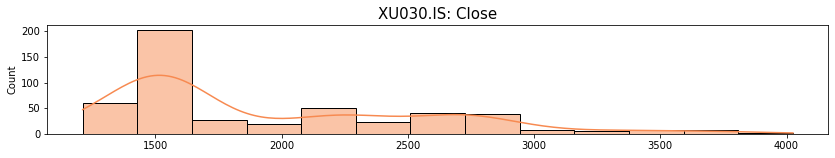

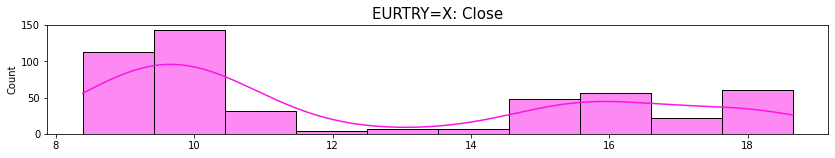

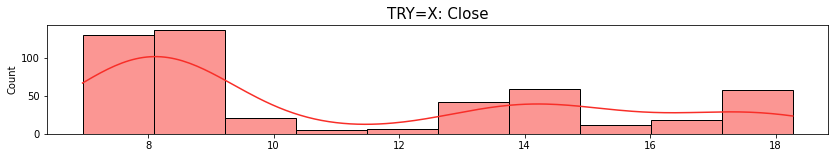

In [38]:
get_stocks_histplot(dataframe_stocks, stocks_list)

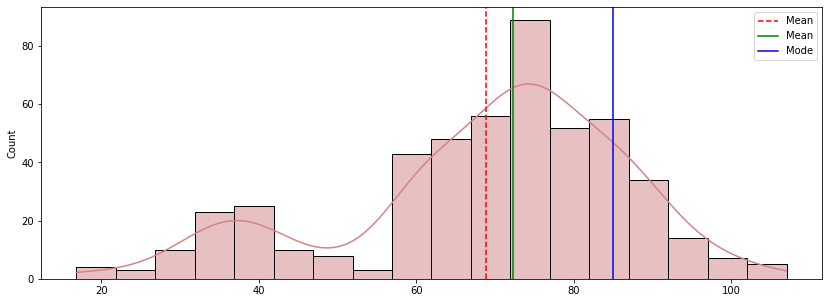

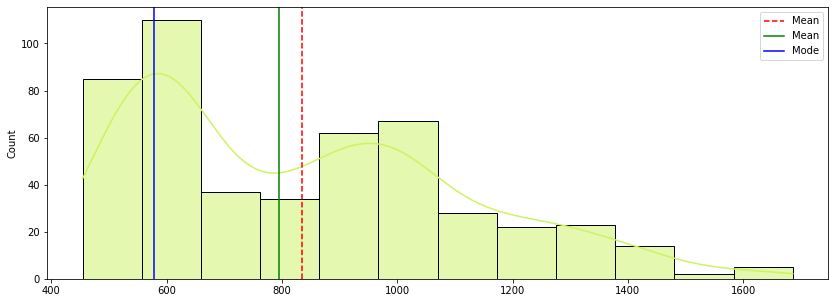

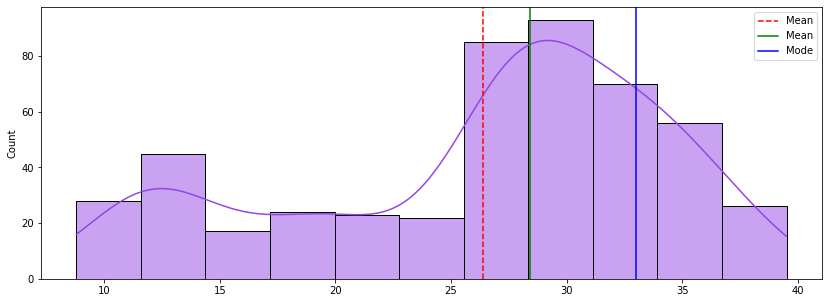

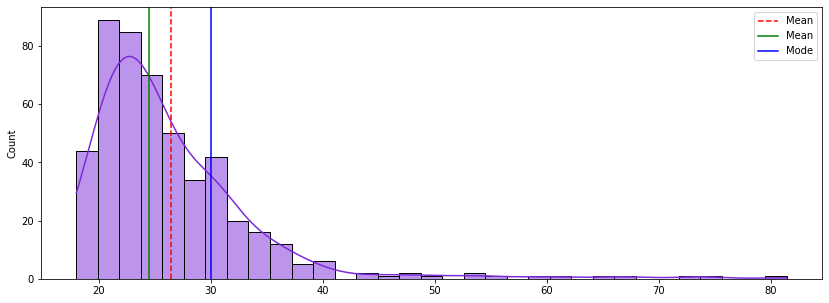

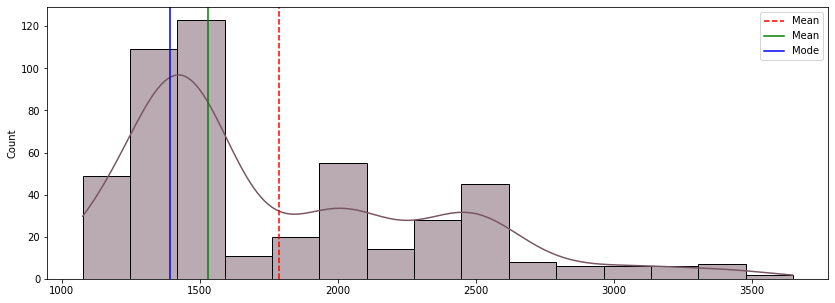

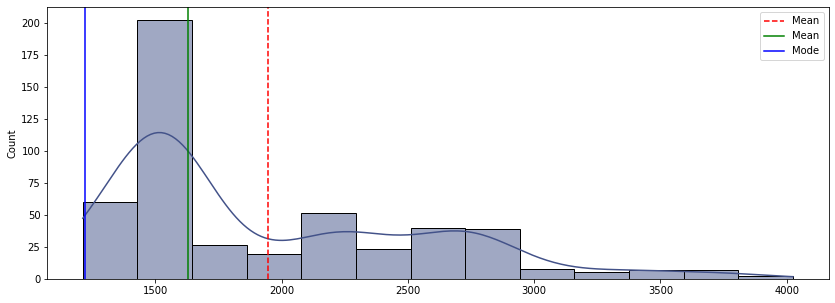

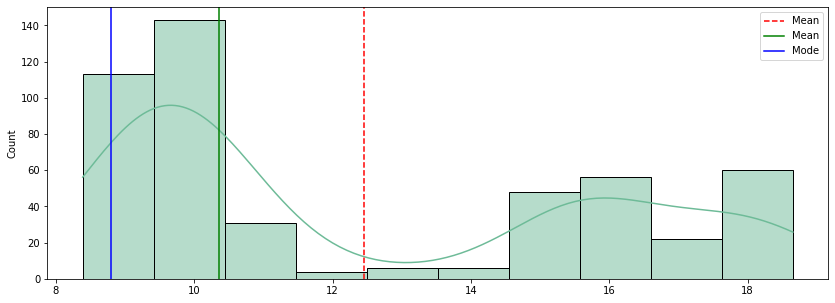

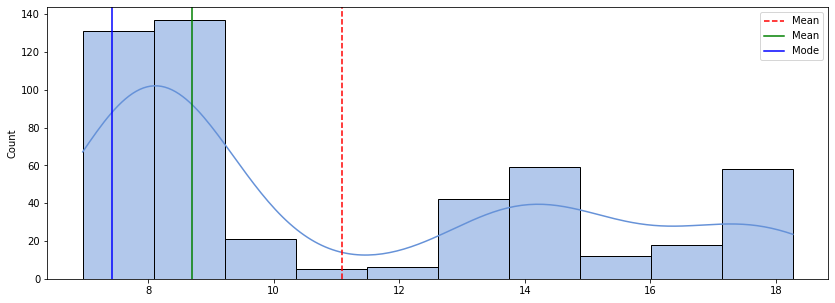

In [39]:
get_stock_histplot_central_tendency(dataframe_stocks, stocks_list)

2020         AxesSubplot(0.1,0.559091;0.363636x0.340909)
2021    AxesSubplot(0.536364,0.559091;0.363636x0.340909)
2022             AxesSubplot(0.1,0.15;0.363636x0.340909)
dtype: object

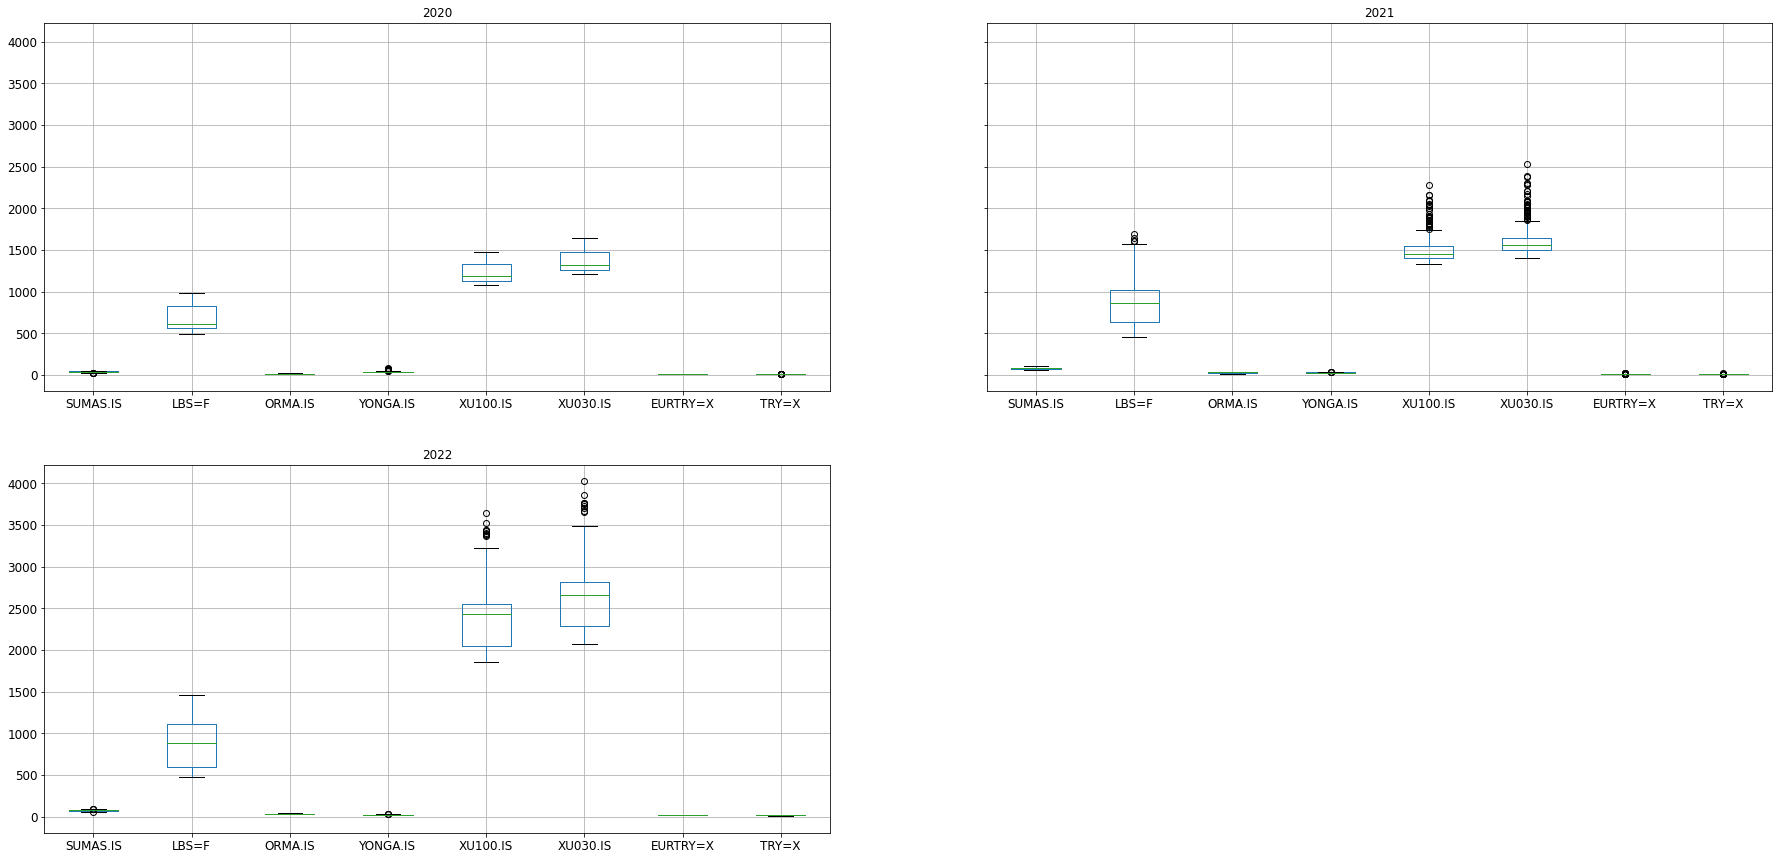

In [40]:
dataframe_stocks.groupby(dataframe_stocks.index.year).boxplot(figsize=(30, 15), fontsize=12)

In [41]:
def get_data_normalize(df: dict):
    dataframe_stocks_norm = df.copy()
    for stock in dataframe_stocks_norm.columns[:-1]:
        dataframe_stocks_norm[stock] =  round(dataframe_stocks_norm[stock] / dataframe_stocks_norm[stock][0], 3)
    return dataframe_stocks_norm

In [42]:
dataframe_stocks_norm = get_data_normalize(dataframe_stocks)
show_table(dataframe_stocks_norm.head(10))

In [43]:
stock_plot_line(dataframe_stocks_norm, stocks_list, title='Stocks price - close: normalized')

# Rate of return

In [44]:
def get_rate_return_log(df: dict, stock_name: str):
    return np.log(df[stock_name][len(df)-1] / df[stock_name][0])

def get_rate_return_daily(df: dict, stock_name: str):
    return (df[stock_name] / df[stock_name].shift(1)) - 1
    
def get_rate_return(df: dict, stock_name: str):
    Xfinal = df[stock_name][len(df) - 1]
    Xstart = df[stock_name][0]
    stock_return_rate = round(((Xfinal - Xstart) / Xstart) * 100, 1)
    return stock_return_rate

def get_all_rate_return_daily(df: dict, stock_list: list):
    df_copy = df.copy()
    for stock in stock_list:
        df_copy[f"{stock}_Rate"] = get_rate_return_daily(df_copy, stock)
    return df_copy

def get_all_rate_return_log(df: dict, stock_list: list):
    stock_name = list()
    stock_value = list()
    for stock in stock_list:
        stock_name.append(stock)
        stock_value.append(get_rate_return_log(df, stock))
    return {'stock': stock_name, 'rate': stock_value}

def get_all_rate_return(df: dict, stock_list: list):
    stock_name = list()
    stock_value = list()
    for stock in stock_list:
        stock_name.append(stock)
        stock_value.append(get_rate_return(df, stock))
    return {'stock': stock_name, 'rate': stock_value}
        

In [45]:
stock_rate_return = get_all_rate_return(dataframe_stocks, stocks_list)
stock_rate_return_log = get_all_rate_return_log(dataframe_stocks, stocks_list)
stock_rate_return_daily = get_all_rate_return_daily(dataframe_stocks, stocks_list)

stock_rate_return = pd.DataFrame.from_dict(stock_rate_return)
stock_rate_return_log = pd.DataFrame.from_dict(stock_rate_return_log)
show_table(stock_rate_return.head())

In [46]:
show_table(stock_rate_return_log.head())

In [47]:
stock_rate_return["Color"] = np.where(stock_rate_return["rate"] < 0, 'red', 'green')
stock_rate_return_log["Color"] = np.where(stock_rate_return_log["rate"] < 0, 'red', 'green')
show_table(stock_rate_return.head())

In [48]:
show_table(stock_rate_return_log.head())

In [49]:
def get_plot_rate_return(stock_rate_return: dict):
    fig = go.Figure()
    fig.add_trace(
        go.Bar(name='rate',
               x=stock_rate_return['stock'],
               y=stock_rate_return['rate'],
               marker_color=stock_rate_return['Color']))
    fig.update_layout(barmode='stack', title="Rate return in period", paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

get_plot_rate_return(stock_rate_return)

# Wallet rate of return

In [50]:
wallet_stock_list = ["SUMAS.IS", "ORMA.IS", "XU100.IS"]
create_stock_wallet = download_list_stocks(wallet_stock_list, "Close", "2020-09-01", "2022-09-18")
show_table(create_stock_wallet.head(10))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [51]:
create_stock_wallet = format_index(create_stock_wallet)
create_stock_wallet_norm = get_data_normalize(create_stock_wallet)
create_stock_wallet_norm.drop(labels=['DateIndex'], axis=1, inplace=True)
wallet_return = (create_stock_wallet_norm / create_stock_wallet_norm.shift(1)) - 1
wallet_weight = np.array([0.2, 0.4, 0.4])
show_table(create_stock_wallet.head(10))

In [52]:
stock_plot_line(create_stock_wallet, wallet_stock_list, title='Stocks price wallet - close: normalized')

In [53]:
year_return_rate = wallet_return.mean() * 246

In [54]:
def plot_indicator_return(value):
    fig = go.Figure()
    color = 'green'
    if value < 0:
        color = 'red'
    if value == 0:
        color = 'black'
    
    fig.add_trace(go.Indicator(number={'font_color': color},
        mode = "number+delta",
        value = value * 100,
        title = {"text": "Rate Wallet %"},
        domain = {'x': [0, 0.5], 'y': [0, 0.5]}))
    
    fig.show()

plot_indicator_return(np.dot(year_return_rate, wallet_weight))

# Year rate return 

In [55]:
stocks_std = dataframe_stocks.describe()

In [56]:
show_table(pd.DataFrame(stocks_std.iloc[2]))

In [57]:
def year_rate_return(df: str, start_date: str, end_date: str, stock_list: list):
    ret_value = dict()
    for stock_name in stock_list:
        xi_v = df[stock_name][df.index == start_date].tolist()
        yi_v = df[stock_name][df.index == end_date].tolist()
        if xi_v and yi_v:
            rate = round(np.log(yi_v[0] / xi_v[0]) * 100, 2)
            ret_value[stock_name] = rate
    return ret_value

In [59]:
year_rate = year_rate_return(dataframe_stocks, '2020-09-01', '2021-09-01', stocks_list)

In [60]:
filter_dates = [
            {"s": "2020-09-01", "f": "2021-09-01"},
            {"s": "2021-09-01", "f": "2022-09-01"},
]
rate_lst = []
for filter_date in filter_dates:
    xi, yi = filter_date["s"], filter_date["f"]
    rate_stocks = year_rate_return(dataframe_stocks, xi, yi, ["YONGA.IS"])
    rate_lst.append(rate_stocks["YONGA.IS"])
    
rate_lst = np.array(rate_lst)

# Risk analysis - using var and std

In [61]:
avg_stock = round(rate_lst.mean(), 2)
var_stock = round(rate_lst.var(), 2)
std_stock = round(rate_lst.std(), 2)

print(f'YONGA.IS, avg:{avg_stock}, var:{var_stock}, std:{std_stock}')

YONGA.IS, avg:-4.81, var:559.8, std:23.66


## Variance coefficient - risk

In [62]:
r_value = {}
avaliation_stocks = ["XU100.IS", "YONGA.IS"]
for avaliation in avaliation_stocks:
    r_value[avaliation] = []
    
for filter_date in filter_dates:
    xi, yi = filter_date["s"], filter_date["f"]
    rate_stocks = year_rate_return(dataframe_stocks, xi, yi, avaliation_stocks)
    for stock_name in rate_stocks:
        r_value[stock_name].append(rate_stocks[stock_name])
    
df_avaliation_compare = pd.DataFrame(r_value)
show_table(df_avaliation_compare)

In [63]:
show_table(df_avaliation_compare.describe())

# Correlation

In [64]:
import math 

def get_return_rate(df: dict):
    return (df/ df.shift(1)) - 1

def get_return_rate_norm(df: dict):
    df_year = df.std() * math.sqrt(246)
    return df_year

dataframe_sample = dataframe_stocks.copy()
dataframe_sample.drop(labels = ['DateIndex'], axis=1, inplace=True)
dataframe_sample_return_rate = get_return_rate(dataframe_sample)

In [65]:
dataframe_sample_return_rate_norm = get_return_rate_norm(dataframe_sample_return_rate)
round(dataframe_sample_return_rate_norm * 100, 2)

SUMAS.IS    79.86
LBS=F       73.13
ORMA.IS     77.06
YONGA.IS    72.34
XU100.IS    25.79
XU030.IS    27.73
EURTRY=X    28.11
TRY=X       27.85
dtype: float64

In [66]:
def get_headmap_stocks(df: dict, correlation_type: str):
    plt.figure(figsize=(18, 18))
    if correlation_type == "corr":
        sns.heatmap(df.corr(), annot=True, cmap='BrBG_r')
        plt.title("Correlation stock - return rate")
    if correlation_type == "cov":
        sns.heatmap(df.cov(), annot=True, cmap='BrBG_r')
        plt.title("Covariance stock - return rate")

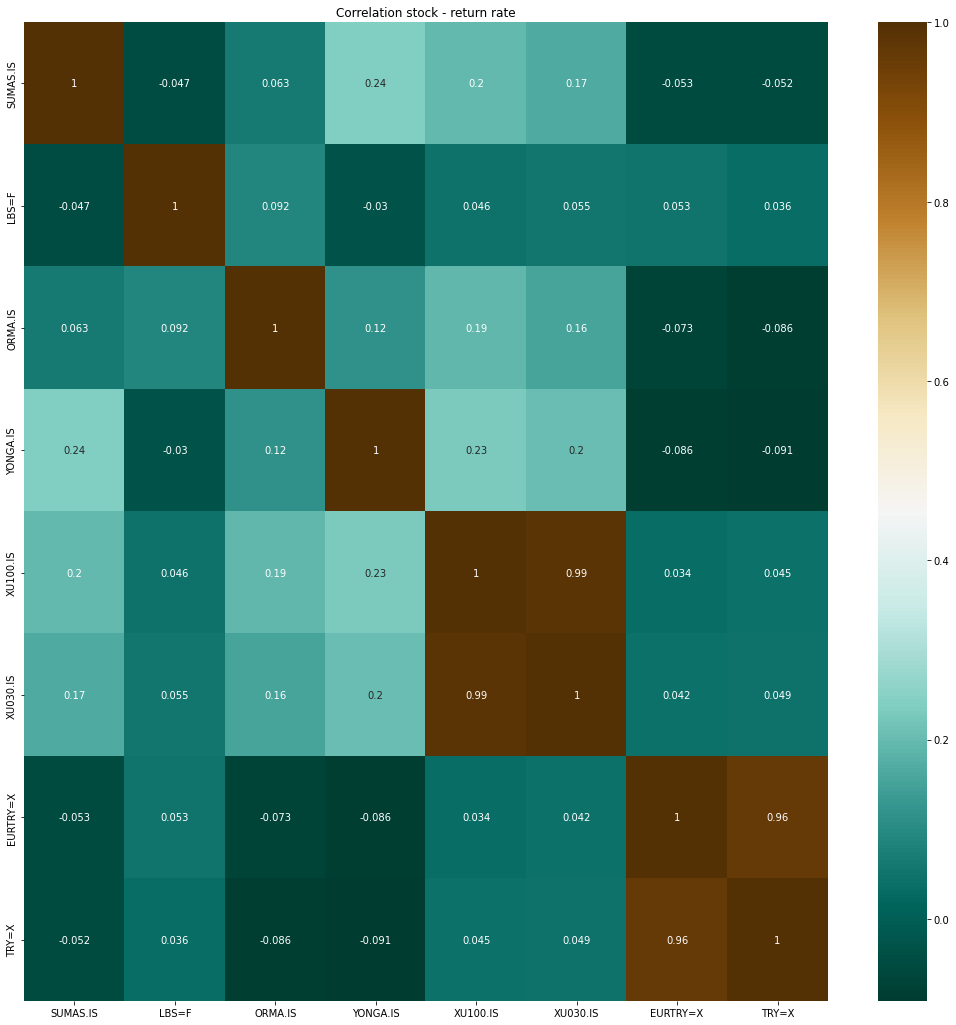

In [67]:
get_headmap_stocks(dataframe_sample_return_rate, "corr")

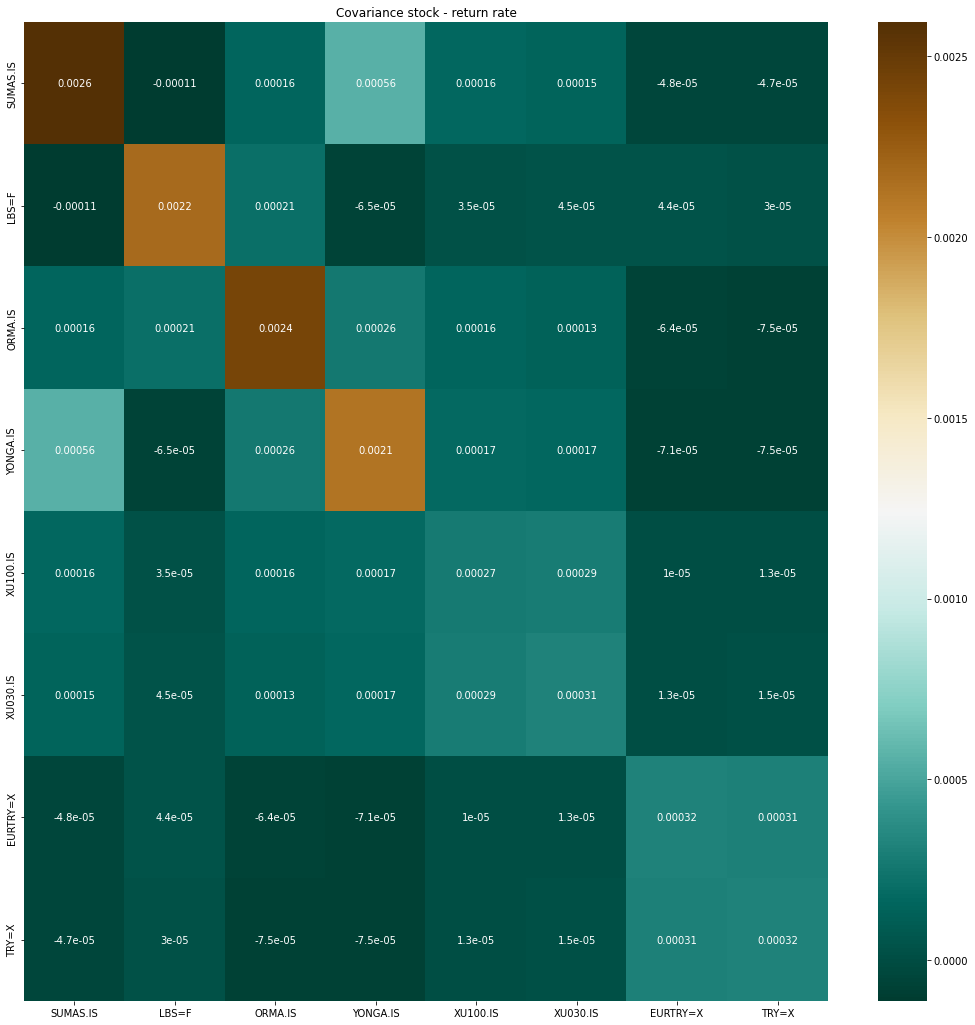

In [68]:
get_headmap_stocks(dataframe_sample_return_rate, "cov")

# Google Trends: Crypto Searchs x Prices

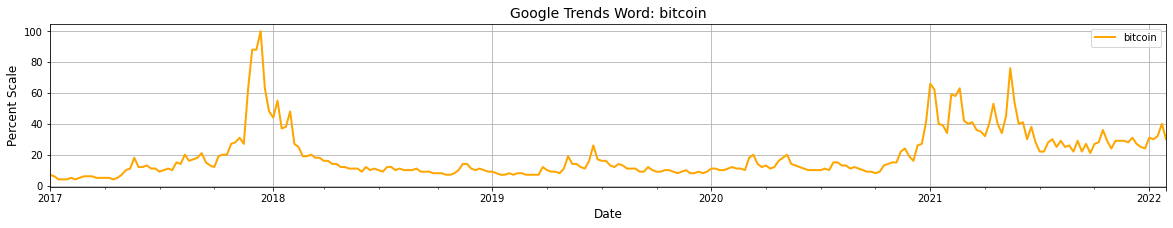

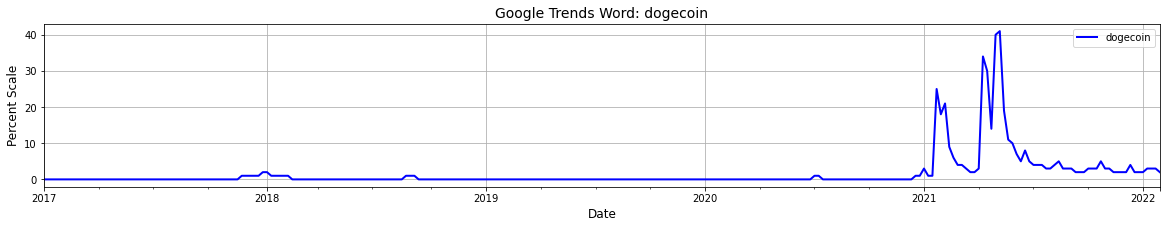

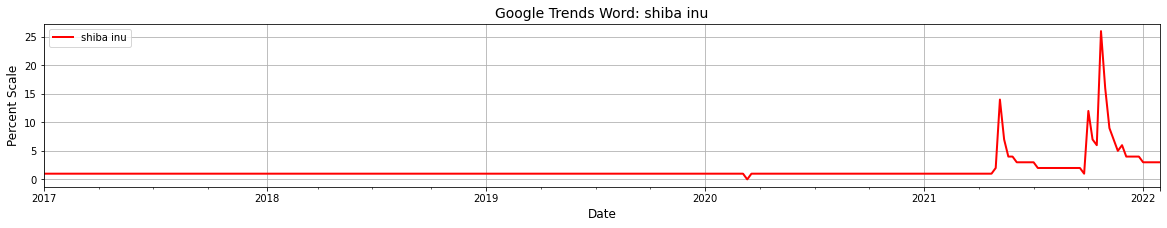

In [69]:
def search_google_trends(word: list, timeframe: str):
    google_trends = TrendReq()
    google_trends.build_payload(word, timeframe=timeframe)
    return google_trends.interest_over_time()

def plot_trend(df: dict, word: str, color: list):
    plt.figure(figsize=(20, 3))
    df[word].plot(lw=2, color=color)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Percent Scale", fontsize=12)
    plt.title(f"Google Trends Word: {word}", fontsize=14)
    plt.legend()
    plt.grid()


timeframe='2017-01-01 2022-02-01'
word_list = ["bitcoin", "dogecoin", "shiba inu"]
color_list = ["orange", "blue", "red"]
dataframe_trends = search_google_trends(word_list, timeframe=timeframe)
for word, color in zip(word_list, color_list):
    plot_trend(dataframe_trends, word, color)

In [70]:
show_table(dataframe_trends.head(10))

In [72]:
list_crypto = ["BTC-USD", "DOGE-USD", "SHIB-USD"]
start_date, end_date = timeframe.split(" ")
dataframe_stock_total = download_list_stocks(list_crypto, "High", start_date, end_date)
dataframe_stock_total = dataframe_stock_total.fillna(0)
dataframe_stock_total["DateIndex"] = pd.to_datetime(dataframe_stock_total.index, unit='s')
show_table(dataframe_stock_total.head(10))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [73]:
def preprocessor_min_max(df: dict, field: str):
    min_max = MinMaxScaler()
    scaled = min_max.fit_transform(df[field].values.reshape(-1, 1))
    df["MinMax"] = scaled * 100
    return df

def preprocessor_min_max_all(df: dict, field_list: list):
    min_max = MinMaxScaler()
    for field in field_list:
        scaled = min_max.fit_transform(df[field].values.reshape(-1, 1))
        df[f"MinMax_{field}"] = scaled * 100
    return df
    
    
dataframe_stock_total = preprocessor_min_max_all(dataframe_stock_total, list_crypto)
show_table(dataframe_stock_total.head(10))

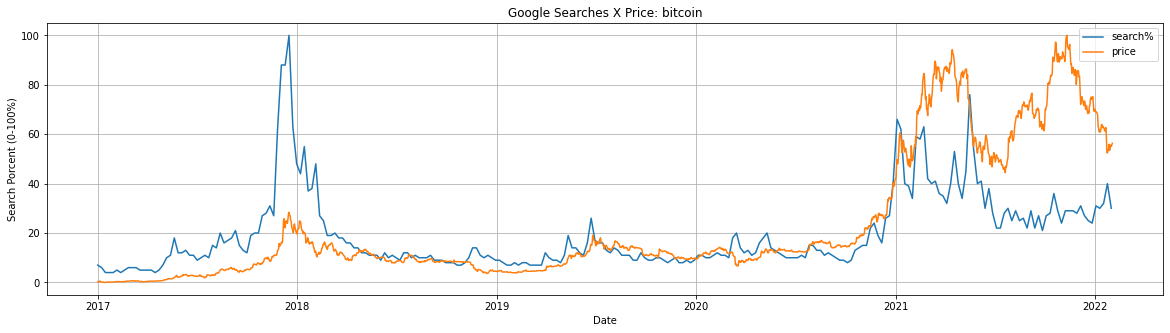

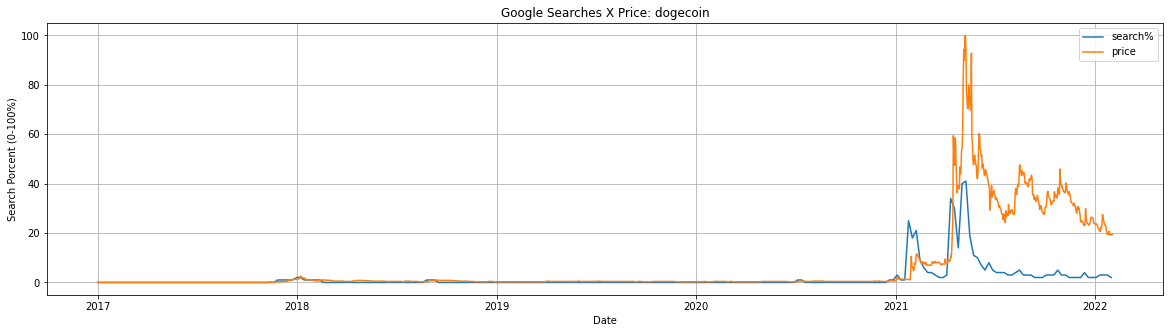

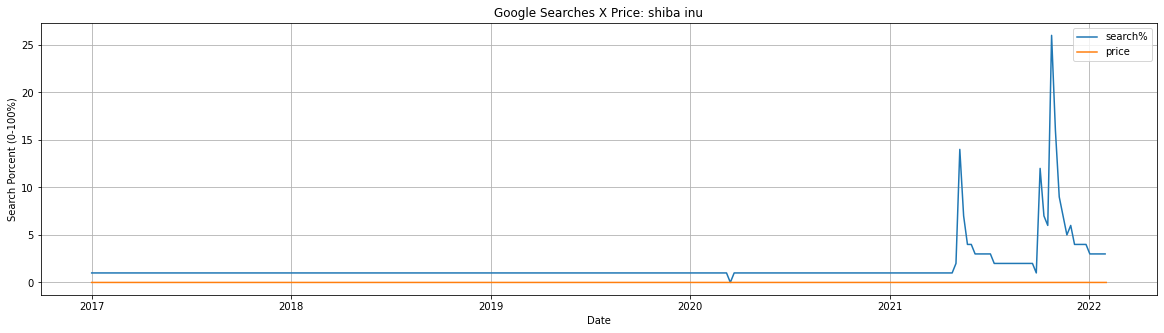

In [74]:
def plot_compare_trends_price(df_trends: dict, df_stocks: dict, word: str):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(f"Google Searches X Price: {word}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Search Porcent (0-100%)")
    ax.plot(df_trends.index, df_trends[word], alpha=1, label="search%")
    ax.plot(df_stocks["DateIndex"], df_stocks["MinMax"], alpha=1, label="price")
    plt.legend()
    plt.grid()

def plot_compare_trends_price_all(df_trends: dict, df_stocks: dict, words: list, list_stock: list):
    for word, stock in zip(words, list_stock):
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title(f"Google Searches X Price: {word}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Search Porcent (0-100%)")
        ax.plot(df_trends.index, df_trends[word], alpha=1, label="search%")
        ax.plot(df_stocks["DateIndex"], df_stocks[f"MinMax_{stock}"], alpha=1, label="price")
        plt.legend()
        plt.grid()

plot_compare_trends_price_all(dataframe_trends, dataframe_stock_total, word_list, list_crypto)

# Monte Carlo Simulation

<img src="https://miro.medium.com/max/1400/1*YcTh0gKplFrZTIZRaBgjJQ.png">

"Monte Carlo methods, or Monte Carlo experiments, are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle. They are often used in physical and mathematical problems and are most useful when it is difficult or impossible to use other approaches. Monte Carlo methods are mainly used in three problem classes: optimization, numerical integration, and generating draws from a probability distribution."

https://en.wikipedia.org/wiki/Monte_Carlo_method

In [76]:
dataframe_simulation = download_dataframe(name='SUMAS.IS', start_date='2019-01-01', end_date='2022-09-18')
dataframe_simulation_norm = get_data_normalize(dataframe_simulation)
dataframe_simulation = dataframe_simulation['Close']
dataframe_simulation_norm = dataframe_simulation_norm['Close']
dataframe_simulation_norm.head(10)

[*********************100%***********************]  1 of 1 completed


Date
2019-01-01    1.000
2019-01-02    0.990
2019-01-03    0.957
2019-01-04    0.991
2019-01-07    0.991
2019-01-08    0.984
2019-01-09    0.986
2019-01-10    0.986
2019-01-11    0.984
2019-01-14    0.983
Name: Close, dtype: float64

In [77]:
dataframe_simulation_rt = np.log(1 + dataframe_simulation_norm.pct_change())
dataframe_simulation_rt.fillna(0, inplace=True)
dataframe_simulation_rt

Date
2019-01-01    0.000000
2019-01-02   -0.010050
2019-01-03   -0.033902
2019-01-04    0.034911
2019-01-07    0.000000
                ...   
2022-09-12    0.014566
2022-09-13    0.000000
2022-09-14   -0.040220
2022-09-15    0.033659
2022-09-16   -0.014663
Name: Close, Length: 938, dtype: float64

In [78]:
drift = dataframe_simulation_rt.mean() - (0.5 * dataframe_simulation_rt.var())
print(f"Drift: {drift}")

Drift: 0.0016496751252035066


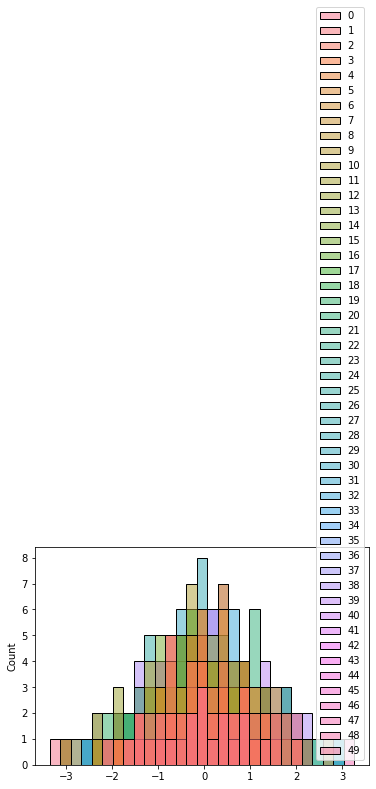

In [79]:
days_prev_len = 30
simulations = 50
Z = stats.norm.ppf(np.random.rand(days_prev_len, simulations))
sns.histplot(Z)

In [80]:
def get_plot_pred(predictions: list):
    fig = px.line(title = 'Simulations')
    for i in range(len(predictions.T)):
        fig.add_scatter(y = predictions.T[i], name = i)
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

df_std = dataframe_simulation_rt.std()
days_rt = np.exp(drift + df_std * Z)
days_pred = np.zeros_like(days_rt)
days_pred[0] = dataframe_simulation.iloc[-1]

for i in range(1, days_prev_len):
    days_pred[i] = days_pred[i - 1] * days_rt[i]
get_plot_pred(days_pred)

In [82]:
dataframe_stock_new = download_dataframe(name='SUMAS.IS', start_date='2019-01-01', end_date='2022-09-18')
dataframe_stock_new = dataframe_stock_new['Close']

s = days_pred.T[0][0:len(dataframe_stock_new)]

[*********************100%***********************]  1 of 1 completed


In [83]:
from sklearn.metrics import mean_absolute_error

dataframe_stock_new = dataframe_stock_new[0:days_prev_len]
mean_absolute_error(dataframe_stock_new, s)

sqerror = list()
for i in range(len(days_pred.T)):
    sqerror.append(mean_absolute_error(dataframe_stock_new, days_pred.T[i][0:days_prev_len]))

In [84]:
def plot_best_predict(df: dict, index_max: int, index_min: int):
    fig = px.line(title='Predict Simulation - Monte Carlo', markers=True)
    fig.add_scatter(y=df, name='value')
    fig.add_scatter(y=days_pred.T[index_max], name='biggest pred error')
    fig.add_scatter(y=days_pred.T[index_min], name='smallest pred error')
    fig.update_traces(mode='markers+lines')
    fig.update_layout(paper_bgcolor='white', plot_bgcolor="white", font_color="black")
    fig.show()

index_min = np.argmin(sqerror)
index_max = np.argmax(sqerror)
plot_best_predict(dataframe_stock_new, index_max, index_min)

# Times Series Predict: ARIMA

In [86]:
times_series = download_dataframe(name='SUMAS.IS', start_date='2019-01-01', end_date='2022-09-18')
times_series_v2 = times_series.copy()

[*********************100%***********************]  1 of 1 completed


In [87]:
times_series.dropna(inplace=True)
times_series = times_series['Close']
len(times_series)

938

In [88]:
percent = int(len(times_series) * 0.90)
times_series_train = times_series[:percent]
times_series_test = times_series[percent:]

print(f'Train: {len(times_series_train)}, Test: {len(times_series_test)}')

print(f'Train > First_date: {times_series_train.index.min()} - Final_date: {times_series_train.index.max()}')
print(f'Test > First_date: {times_series_test.index.min()} - Final_date: {times_series_test.index.max()}')
 

Train: 844, Test: 94
Train > First_date: 2019-01-01 00:00:00 - Final_date: 2022-04-27 00:00:00
Test > First_date: 2022-04-28 00:00:00 - Final_date: 2022-09-16 00:00:00


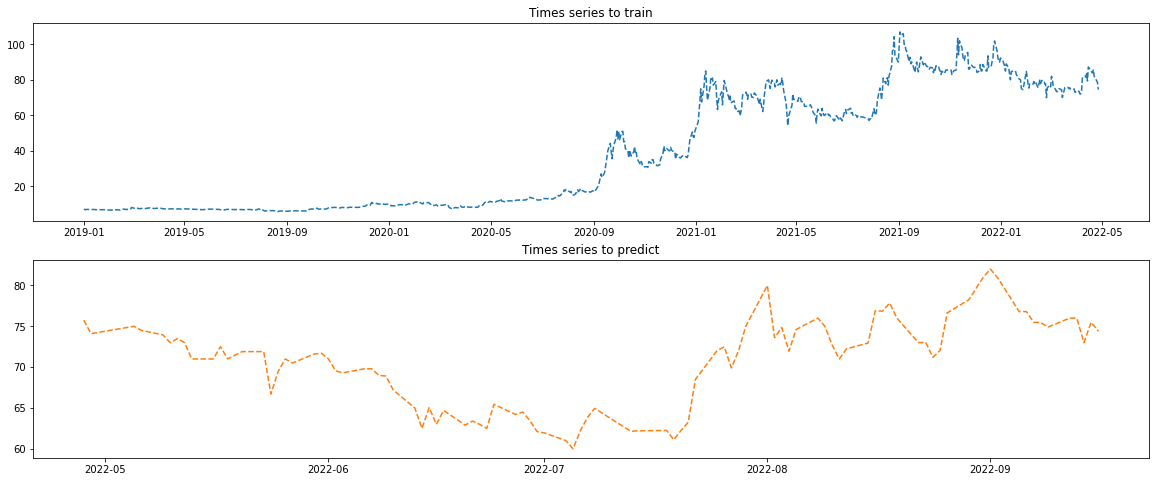

In [89]:
def plot_line(df_1: dict, df_2: dict):
    fig = plt.figure(figsize=(20, 8))
    plt.subplot(211)
    plt.title("Times series to train")
    plt.plot(df_1, color='tab:blue', linestyle='--')

    plt.subplot(212)
    plt.title("Times series to predict")
    plt.plot(df_2, color='tab:orange', linestyle='--')
    plt.show()


def plot_line_tedency(df: dict):

    fig = plt.figure(figsize=(20, 8))
    plt.subplot(211)
    plt.title("Times series - trend")
    plt.plot(df.trend, color='tab:blue', linestyle='--')

    plt.subplot(212)
    plt.title("Times series - resid")
    plt.plot(df.resid, color='tab:orange', linestyle='--')


times_series.head(10)
plot_line(times_series_train, times_series_test)

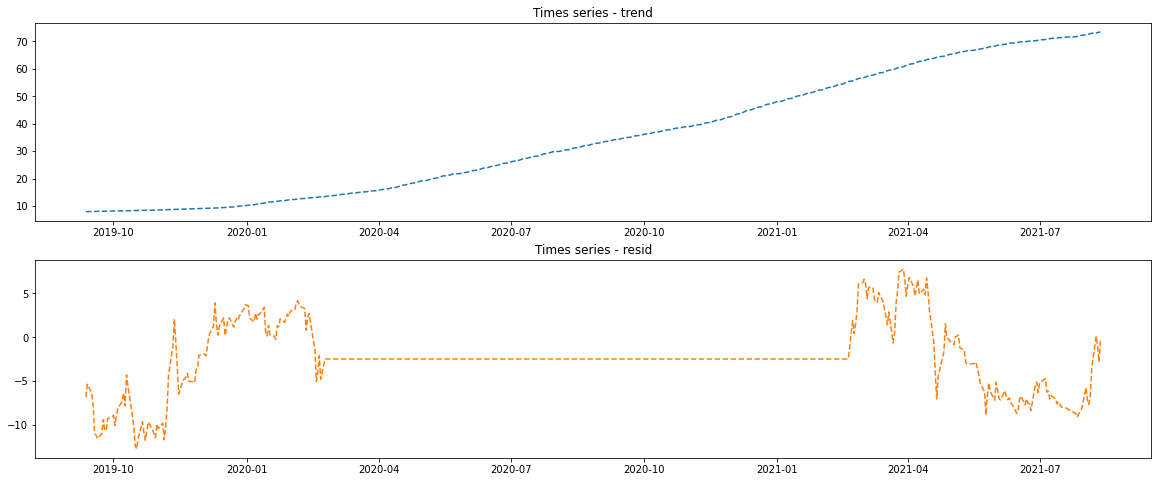

In [90]:
times_series_stats = seasonal_decompose(times_series_train, period=365)
plot_line_tedency(times_series_stats)

In [91]:
def build_model(times_series_train: dict):
    return auto_arima(times_series_train, suppress_warnings=True, error_action='ignore')


def model_predict(model, period):
    return model.predict(n_periods=period)

In [92]:
model = build_model(times_series_train)
pred = model_predict(model, len(times_series_test))
pred = pd.DataFrame(pred, columns=['pred_value'], index=times_series_test.index)
show_table(pred.head(20))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [93]:
def plot_arima_pred(train: dict, test: dict, pred: dict):
    plt.figure(figsize=(20, 4))
    config = {'name': ['train', 'test', 'predict'],
              'color': ['green', 'orange', 'red'],
              'data': [train, test, pred]}
              
    for i in range(3):
        plt.plot(config['data'][i], label=config['name'][i], color=config['color'][i])
    plt.legend()

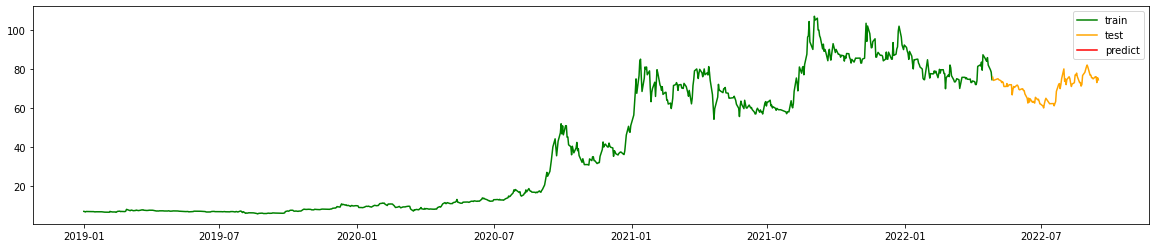

In [94]:
plot_arima_pred(times_series_train, times_series_test, pred)

In [95]:
print(f'Absolute error: {mean_absolute_error(times_series_test, pred)}')

ValueError: ignored

# Times Series Predict: Prophet

In [ ]:
times_series_v2 = format_index(times_series_v2)
times_series_v2.reset_index(drop=True, inplace=True)
times_series_v2 = times_series_v2[["DateIndex", "Close"]]
times_series_v2 = times_series_v2[["DateIndex", "Close"]].rename(columns={'Close': 'y', 'DateIndex': 'ds'})
times_series_train_v2 = times_series_v2.iloc[:percent, [0, 1]]
times_series_test_v2 = times_series_v2.iloc[percent:, [0, 1]]

In [ ]:
print(f"Train: {len(times_series_train_v2)} Test: {len(times_series_test_v2)}")
model_prophet = Prophet()
model_prophet.fit(times_series_train_v2)

Train: 2919 Test: 325


Initial log joint probability = -50.8748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6154.72     0.0359155       1133.37           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6395.95     0.0163975       500.458           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6547.91      0.182229       1399.93           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6618.48    0.00469747       315.337           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6656.21     0.0316761       257.642           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [ ]:
pred_prophet = model_prophet.predict(model_prophet.make_future_dataframe(periods=len(times_series_test_v2)))
predict = pred_prophet['yhat'].tail(len(times_series_test_v2))
error = mean_absolute_error(times_series_test_v2['y'], predict)
print(f"Mean absolute error: {error}")

Mean absolute error: 3.948514256847775


In [ ]:
plot_plotly(model_prophet, pred_prophet)